# Импорт библиотек

In [56]:
import pandas as pd
from datetime import datetime
import re
import json
import os

import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from category_encoders import BinaryEncoder

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, make_scorer, classification_report

from imblearn.under_sampling import RandomUnderSampler


# Чтение данных

In [2]:
all_data = []
# Перебираем все файлы в директории
for filename in os.listdir('data'):
    if filename.endswith('.json'): # Проверяем, что файл имеет расширение .json
        file_path = os.path.join('data', filename)
        # Открываем
        with open(file_path, 'r', encoding='utf-8') as file:
            data = [json.loads(line) for line in file]
            all_data.extend(data)

In [3]:
data_df = pd.DataFrame(all_data)
# Так как в данных есть списки со словарями, преобразуем их просто в словари, чтобы можно было преобразить данные в DataFrame без словарей:
# Ключи словарей станут новыми признаками в DataFrame 
def convert_list_to_dict(cell):
    if isinstance(cell, list) and len(cell) > 0:
        return cell[0]
    else:
        return cell

# Применение функции к каждой ячейке в каждом столбце DataFrame
for column in data_df.columns:
    data_df[column] = data_df[column].apply(convert_list_to_dict)

In [4]:
# Преобразуем данные в json, чтобы открыть через json_normalize, сразу добавив ключи, как признаки
data_df_1 = pd.DataFrame(data_df)

clear_json = data_df_1.to_json(orient='records')

data_list = json.loads(clear_json)

full_data = pd.json_normalize(data_list)
# отсортируем признаки по алфавиту
full_data = full_data.sort_index(axis=1)

In [5]:
# Запишем в  готовую таблицу в csv файл
full_data.to_csv('data/Полная таблица.csv')


# Знакомство с данными

In [6]:
df = pd.read_csv('data/Полная таблица.csv')
df.drop('Unnamed: 0', axis=1, inplace=True)
df.head()

C:\Users\Aplatonov\AppData\Local\Temp\ipykernel_15688\2871854370.py:1: DtypeWarning: Columns (171,175,177,179,182,201,202,203,204,205,206,211,214,215) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('data/Полная таблица.csv')


,addOkved,addOkved.code,addOkved.name,addOkved.version,address,administrators,administrators.name,administrators.title,charter,dateLiquid,...,socialMedia.youtube,statusDetail.code,statusDetail.name,statusDetail.shortName,successors,successors.fullName,successors.inn,successors.ogrn,website,website_punycode
0,[],NaN,NaN,NaN,"191186, ГОРОД САНКТ-ПЕТЕРБУРГ, УЛИЦА ИТАЛЬЯНСК...",NaN,КОШЕЧКИН ДЕНИС ВИКТОРОВИЧ,ПРЕДСЕДАТЕЛЬ ПРАВЛЕНИЯ,NaN,NaN,...,NaN,NaN,NaN,Действующая,[],NaN,NaN,NaN,NaN,NaN
1,NaN,58.11,Издание книг,ОК 029-2014 (КДЕС Ред. 2),"111395, ГОРОД МОСКВА, УЛИЦА МОЛДАГУЛОВОЙ, ДОМ ...",NaN,НИЗАМИЕВ РУСЛАН ВИЛЬДАНОВИЧ,ГЕНЕРАЛЬНЫЙ ДИРЕКТОР,NaN,NaN,...,NaN,NaN,NaN,Действующая,[],NaN,NaN,NaN,NaN,NaN
2,[],NaN,NaN,NaN,"197198, ГОРОД САНКТ-ПЕТЕРБУРГ, УЛИЦА БОЛЬШАЯ П...",NaN,САМОЙЛОВА АНЖЕЛА ВАСИЛЬЕВНА,ПРЕДСЕДАТЕЛЬ КОЛЛЕГИИ,NaN,NaN,...,NaN,NaN,NaN,Действующая,[],NaN,NaN,NaN,NaN,NaN
3,NaN,68.20,Аренда и управление собственным или арендованн...,ОК 029-2014 (КДЕС Ред. 2),"125424, ГОРОД МОСКВА, ШОССЕ ВОЛОКОЛАМСКОЕ, ДОМ...",NaN,ГЕЛЬДТ ВЛАДИМИР АНДРЕЕВИЧ,ПРЕДСЕДАТЕЛЬ ТОВАРИЩЕСТВА,NaN,NaN,...,NaN,NaN,NaN,Действующая,[],NaN,NaN,NaN,NaN,NaN
4,NaN,73.20,Исследование конъюнктуры рынка и изучение обще...,ОК 029-2014 (КДЕС Ред. 2),"197198, ГОРОД САНКТ-ПЕТЕРБУРГ, УЛИЦА ЗВЕРИНСКА...",NaN,ПРИВАЛОВА ЮЛИЯ АНАТОЛЬЕВНА,ДИРЕКТОР,NaN,NaN,...,NaN,NaN,NaN,Действующая,[],NaN,NaN,NaN,NaN,NaN


In [7]:
print(df.info(verbose=True))


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 747034 entries, 0 to 747033
Data columns (total 215 columns):
 #    Column                                Dtype  
---   ------                                -----  
 0    addOkved                              object 
 1    addOkved.code                         object 
 2    addOkved.name                         object 
 3    addOkved.version                      object 
 4    address                               object 
 5    administrators                        object 
 6    administrators.name                   object 
 7    administrators.title                  object 
 8    charter                               float64
 9    dateLiquid                            float64
 10   dateLiquid.$date                      object 
 11   dateOgrn.$date                        object 
 12   dateReg                               float64
 13   dateReg.$date                         object 
 14   egrulStatus                           object 
 15 

In [8]:
missing_percentage = df.isnull().mean() * 100
print(f'В данных {missing_percentage[missing_percentage == 0].count()} признаков без записей (только пропуски) и {missing_percentage[(missing_percentage != 0) & (missing_percentage <= 10)].count()} признаков, где до 10% записей')
# Признаки только с пропусками можно удалить
df_no_nan = df.dropna(axis=1, how='all')

В данных 21 признаков без записей (только пропуски) и 10 признаков, где до 10% записей


# Очистка данных

In [9]:
# Просмотрим все признаки типа object
object_columns = df.select_dtypes(include=['object'])
print(len(object_columns.columns), 'столбцов object')

47 столбцов object


In [10]:
df.shape

(747034, 215)

In [11]:
lest_obj = []
for col in object_columns.columns:
    if df[col].nunique() == 1: # выберем столбцы, в которых одина уникальная запись
        lest_obj.append(col)
        print(df[col].value_counts())

addOkved
[]    474366
Name: count, dtype: int64
administrators
[]    48722
Name: count, dtype: int64
predecessors
[]    735550
Name: count, dtype: int64
reports
[]    614158
Name: count, dtype: int64
socialMedia.instagram
https://www.instagram.com/crimea24news    1
Name: count, dtype: int64
successors
[]    732281
Name: count, dtype: int64


In [12]:
# Так как это просто пустые списки и одна ссылка на соцсеть, можно удалить эти признаки
df_no_nan = df.drop(columns=lest_obj)

In [13]:
df_no_nan.shape
# Количество кризнаков сократилось в четыре раза 

(747034, 209)

In [14]:
df_no_nan.to_csv('data/Полная таблица очищенная.csv')

### Проанализируем признаки

In [3]:
df_full = pd.read_csv('data/Полная таблица очищенная.csv')
df_full = df_full.copy()

C:\Users\Aplatonov\AppData\Local\Temp\ipykernel_13868\3928868559.py:1: DtypeWarning: Columns (169,173,175,177,180,197,198,199,200,201,205,208,209) have mixed types. Specify dtype option on import or set low_memory=False.
  df_full = pd.read_csv('data/Полная таблица очищенная.csv')


In [4]:
df_full.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 747034 entries, 0 to 747033
Columns: 210 entries, Unnamed: 0 to website_punycode
dtypes: bool(1), float64(160), int64(8), object(41)
memory usage: 1.2+ GB


- От дополнительного ОКВЭД вдяд ли есть зависимость одобрения гранта - удаляем
- Точный адрес тоже не должен влиять (посммотрим позже на регион и город) - удаляем
- Имя руководителя как и должность тоже ничего не должно значить - удаляем
- ИНН и КПП не влияют - удаляем
- Код основного ОКВЭД и  его версия ничего нам не скажет (оставиим название) - удаляем
- Дата ликвидации юрлица - удаляем
- Реестровый номер НКО в системе Минюста РФ - удаляем
- ОГРН - удаляем
- код ОКАТО точно не нужен, оставим расшифровку
- код ОКФС - удаляем
- код ОКОГУ - удаляем
- код ОКТМО - удаляем
- код ОПФ и версия- удаляем
- ID отчета и тип - удаляем
- Сокращенное наименование организации - удаляем

- Статус НКО в системе Минюста РФ не должен влиять на одобрение гранта, но пока оставим

Остальные признаки будем обрабатывать.   
Возможно, ещё что-то удалим в процессе

hasRegionalSupport - целевой признак одобрения получения региональной поддержки

In [5]:
del_list = ['Unnamed: 0',
    'addOkved.code',
    'addOkved.version',
    'address',
    'administrators.name',
    'administrators.title',
    'dateLiquid.$date',
    'inn',
    'kpp',
    'mainOkved.code',
    'mainOkved.version',
    'ogrn',
    'okato.code',
    'okfs.code',
    'okogu.code',
    'oktmo.code',
    'opf.code',
    'opf.version',
    'reports.reportId',
    'reports.type',
    'shortName'
]

df_clean = df_full.drop(columns=del_list)

In [6]:
# Вычислим процент Nan-строк в каждом столбце
is_nan = pd.DataFrame()
for column in df_clean.columns:
    num_nan = df_clean[column].isna().sum()
    percentage = (num_nan / len(df_full)) * 100
    is_nan[column] = [percentage]

C:\Users\Aplatonov\AppData\Local\Temp\ipykernel_13868\1626090704.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  is_nan[column] = [percentage]
C:\Users\Aplatonov\AppData\Local\Temp\ipykernel_13868\1626090704.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  is_nan[column] = [percentage]
C:\Users\Aplatonov\AppData\Local\Temp\ipykernel_13868\1626090704.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all c

In [7]:
not_0 = is_nan[is_nan >= 1]
# not_0 = not_0[not_0 == True]
not_0 = not_0.dropna(axis=1)
not_0

,addOkved.name,charter,dateLiquid,dateReg,dateReg.$date,email,incomeDetail.contracts223.2002.count,incomeDetail.contracts223.2002.sum,incomeDetail.contracts223.2004.count,incomeDetail.contracts223.2004.sum,...,socialMedia.twitter,socialMedia.vk,socialMedia.youtube,statusDetail.code,statusDetail.name,successors.fullName,successors.inn,successors.ogrn,website,website_punycode
0,63.499921,100.0,100.0,100.0,56.974381,98.907948,99.999866,99.999866,99.999866,99.999866,...,99.999732,99.999331,99.999732,97.690467,97.690467,98.025123,99.352506,98.025123,99.292402,99.292402


Точно можно удалить признаки об отчётах в Минюст РФ. Скорее всего, они не несут важной информации. К тому же в них больше 80% пропусков.
Расшифровка кода дополнительного ОКВЭД и Расшифровка кода ОКТМО скорее всего имеет значение, но мы не можем её использоввать, так как в ней больше 60% пропусков.  
ОКПО тоже удалим, так как половина - пропуски.  
Из даты ликвидации юрлица вряд ли можно что-то извлечь, тем более больше половины пропусков.  
сокращенное наименование организации  
Нельзя утверждать наверняка, что наименовании организации не влияет на одобряемость, но это сложно проверить. Поэтому при обучении модели можно будет не учитывать этот признак.  

В принципе, можно удалить все признаки в not_0, потому что в них всех много пропусков и не корректно будет заменять значения каким-нибудь средним значением.


In [8]:
df_clean = df_clean.drop(columns=list(not_0.columns))

In [9]:
# Удалим дубликаты и пустые строки
df_clean_dub = df_clean.drop_duplicates() 
df_clean_nan = df_clean_dub.dropna(thresh = int(len(df_clean_dub.columns))*0.2) # удаляем строки, где более 80% пропусков в записи 
print('Количество дубликатов: ', df_clean.shape[0]-df_clean_dub.shape[0])
print('Количество пустых строк: ', df_clean_dub.shape[0]-df_clean_nan.shape[0])

Количество дубликатов:  57
Количество пустых строк:  0


In [10]:
df_clean_nan.isna().sum()

dateOgrn.$date                            0
egrulStatus                               0
fullName                                  0
hasRegionalSupport                        0
incomeDetail.contracts223.totalCount      0
incomeDetail.contracts223.totalSum        0
incomeDetail.contracts44.totalCount       0
incomeDetail.contracts44.totalSum         0
incomeDetail.contracts94.totalCount       0
incomeDetail.contracts94.totalSum         0
incomeDetail.fedSubsidies.totalCount      0
incomeDetail.fedSubsidies.totalSum        0
incomeDetail.grants.totalCount            0
incomeDetail.grants.totalSum              0
incomeTotal                               0
opf.name                                415
originDate.$date                          0
regionCode                                0
regionName                               25
statusDetail.shortName                    0
dtype: int64

In [11]:
# Удалим оставшиеся пустые значения, так как их совсем мало относительно всего сета
df_clean_nan.dropna(inplace=True)

In [12]:
print(f'После удаления пустых и неподходящих признаков у нас остлось {df_clean_nan.shape[0]} строк и {df_clean_nan.shape[1]} признаков')

После удаления пустых и неподходящих признаков у нас остлось 746537 строк и 20 признаков


# Feature Engineering 

In [13]:
# Добавим признак года и месяца, чтобы проверить, влияет ли дата основании компании на одобрямость
df_clean_nan['originDate.$date'] = pd.to_datetime(df_clean_nan['originDate.$date'])
df_clean_nan['Year_origin'] = df_clean_nan['originDate.$date'].dt.year
df_clean_nan['Month_origin'] = df_clean_nan['originDate.$date'].dt.month

# Добавим признак года и месяца присвоения ОГРН, чтобы проверить, влияет ли это на одобрямость
df_clean_nan['dateOgrn.$date'] = pd.to_datetime(df_clean_nan['dateOgrn.$date'])
df_clean_nan['Year_ogrn'] = df_clean_nan['dateOgrn.$date'].dt.year
df_clean_nan['Month_ogrn'] = df_clean_nan['dateOgrn.$date'].dt.month
# Удаляем дату
df_clean_nan = df_clean_nan.drop(columns=['dateOgrn.$date'])

In [14]:
# Добавим признак Тип субъекта, чтобы проверить влияет ли это на одобряемость.
def get_region_type(region_name):
    region_name_lower = region_name.lower()
    
    if region_name_lower in ['москва', 'севастополь', 'санкт-петербург']:
        return 'Город федерального значения'
    elif re.search(r'край$', region_name_lower):
        return 'край'
    elif re.search(r'область$', region_name_lower):
        return 'область'
    elif re.search(r'республика$', region_name_lower):
        return 'республика'
    elif re.search(r'округ$', region_name_lower):
        return 'автономный округ'
    else:
        return 'Не определено'

df_clean_nan['Region.type'] = df_clean_nan['regionName'].apply(get_region_type)

In [15]:
# Приведём признаки к целому типу
df_clean_nan['regionCode'] = df_clean_nan['regionCode'].astype(int)
df_clean_nan['Year_origin'] = df_clean_nan['Year_origin'].astype(int)

In [16]:
df_clean_nan.info()

<class 'pandas.core.frame.DataFrame'>
Index: 746537 entries, 0 to 747033
Data columns (total 24 columns):
 #   Column                                Non-Null Count   Dtype              
---  ------                                --------------   -----              
 0   egrulStatus                           746537 non-null  object             
 1   fullName                              746537 non-null  object             
 2   hasRegionalSupport                    746537 non-null  bool               
 3   incomeDetail.contracts223.totalCount  746537 non-null  int64              
 4   incomeDetail.contracts223.totalSum    746537 non-null  float64            
 5   incomeDetail.contracts44.totalCount   746537 non-null  int64              
 6   incomeDetail.contracts44.totalSum     746537 non-null  float64            
 7   incomeDetail.contracts94.totalCount   746537 non-null  int64              
 8   incomeDetail.contracts94.totalSum     746537 non-null  float64            
 9   incomeDet

# Предварителньный анализ

Регион регистрации

In [17]:
df_clean_nan['regionName'].value_counts()

regionName
Москва                          79854
Московская область              37915
Санкт-Петербург                 31765
Краснодарский край              23334
Свердловская область            23023
                                ...  
Республика Ингушетия             1248
Еврейская автономная область     1196
Чукотский автономный округ        505
Ненецкий автономный округ         398
Не определено                      91
Name: count, Length: 86, dtype: int64

Логично, что больше всего НКО в самых населённых регионах

In [59]:
region_group = df_clean_nan.pivot_table(index = 'regionName', columns='hasRegionalSupport', aggfunc='size', fill_value=0)
region_group['%_approve'] = round((region_group[True] / region_group.sum(axis=1)) * 100)
region_group.sort_values('%_approve', ascending=False).head(10)

KeyError: 'regionName'

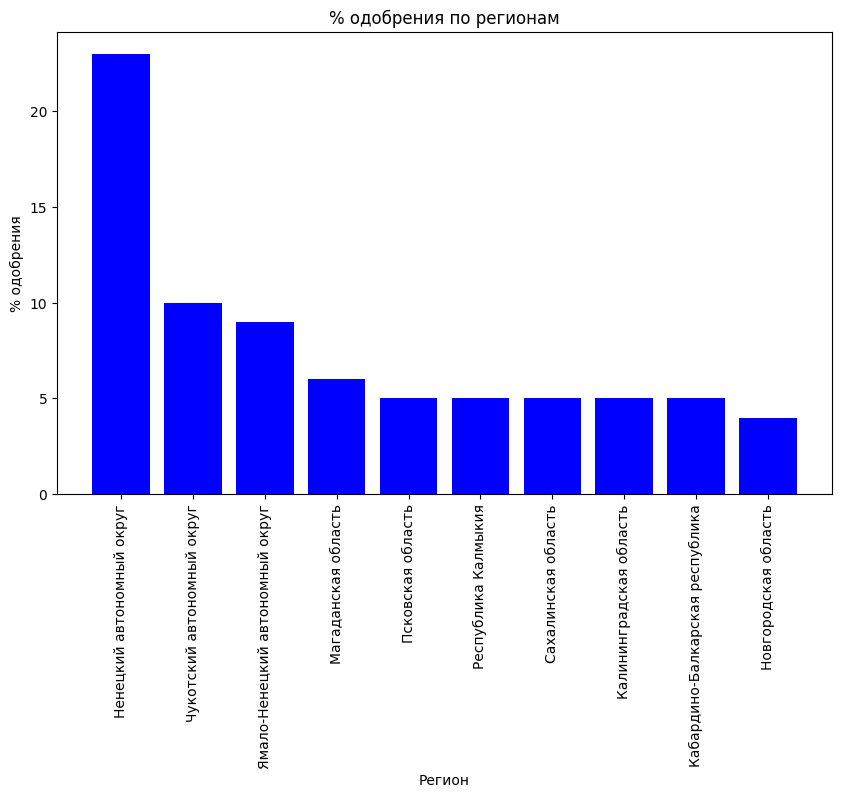

In [60]:
regions_best  = region_group.sort_values('%_approve', ascending=False).head(10)
plt.figure(figsize=(10, 6)) 
plt.bar(regions_best.index, regions_best['%_approve'], color='blue')
plt.xlabel('Регион')
plt.ylabel('% одобрения')
plt.title('% одобрения по регионам')
plt.xticks(rotation=90)
plt.show()

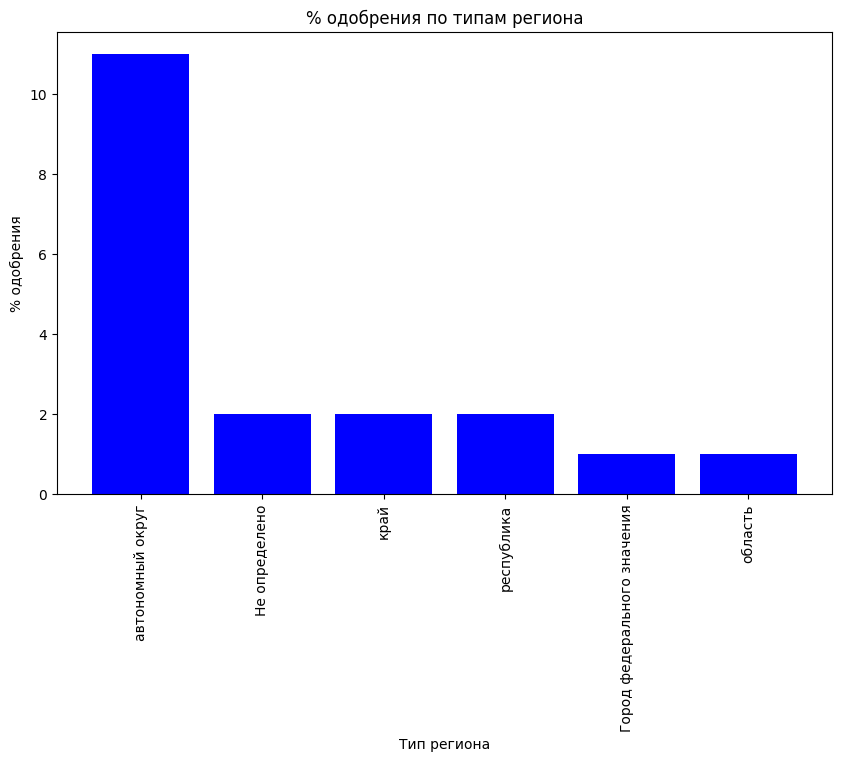

In [61]:
loc_group = df_clean_nan.pivot_table(index = 'Region.type', columns='hasRegionalSupport', aggfunc='size', fill_value=0)
loc_group['%_approve'] = round((loc_group[True] / loc_group.sum(axis=1)) * 100)
loc_best = loc_group.sort_values('%_approve', ascending=False).head(10)

plt.figure(figsize=(10, 6)) 
plt.bar(loc_best.index, loc_best['%_approve'], color='blue')
plt.xlabel('Тип региона')
plt.ylabel('% одобрения')
plt.title('% одобрения по типам региона')
plt.xticks(rotation=90)
plt.show()

Одобряют региональную поддержку в автономных округах в пять раз чаще, чем в других регионах.

Больше всего процент одобрений в НАО и ЧАО.

In [19]:
# Название региона можно удалить, так как есть его код
df_clean_nan = df_clean_nan.drop(columns=['regionName'])

Год основания

In [21]:
df_clean_nan['originDate.$date'] = pd.to_datetime(df_clean_nan['originDate.$date'])
df_clean_nan['originDate.$date'].sort_values().head(10)

37554    1881-01-29 00:00:00+00:00
417948   1900-01-16 00:00:00+00:00
742634   1900-07-05 00:00:00+00:00
423917   1912-01-28 00:00:00+00:00
606649   1922-08-21 00:00:00+00:00
687624   1933-04-15 00:00:00+00:00
237878   1933-07-01 00:00:00+00:00
487425   1933-07-14 00:00:00+00:00
640245   1936-05-07 00:00:00+00:00
303284   1939-02-01 00:00:00+00:00
Name: originDate.$date, dtype: datetime64[ns, UTC]

In [22]:
# Проверим самые старые организации
df_clean_nan[df_clean_nan['originDate.$date'] <= '1940']
# Записи выглядят нормальными, можно оставить

,egrulStatus,fullName,hasRegionalSupport,incomeDetail.contracts223.totalCount,incomeDetail.contracts223.totalSum,incomeDetail.contracts44.totalCount,incomeDetail.contracts44.totalSum,incomeDetail.contracts94.totalCount,incomeDetail.contracts94.totalSum,incomeDetail.fedSubsidies.totalCount,...,incomeTotal,opf.name,originDate.$date,regionCode,statusDetail.shortName,Year_origin,Month_origin,Year_ogrn,Month_ogrn,Region.type
37554,Ликвидирована,"САДОВОДЧЕСКОЕ НЕКОММЕРЧЕСКОЕ ТОВАРИЩЕСТВО ""ПРО...",False,0,0.0,0,0.0,0,0.0,0,...,0.0,"Садоводческие, огороднические или дачные неком...",1881-01-29 00:00:00+00:00,50,Действующая,1881,1,2002,7,область
237878,Ликвидирована,"КООПЕРАТИВ ""ПОЛИСЕРВИС ЦЕНТР""",False,0,0.0,0,0.0,0,0.0,0,...,0.0,Потребительский кооператив,1933-07-01 00:00:00+00:00,27,Действующая,1933,7,2007,5,край
303284,Ликвидирована,"КООПЕРАТИВ ""ГЕРМЕС""",False,0,0.0,0,0.0,0,0.0,0,...,0.0,Потребительские кооперативы,1939-02-01 00:00:00+00:00,29,Действующая,1939,2,2011,10,область
417948,Ликвидирована,РЕМОНТНО-РЕСТАВРАЦИОННЫЙ СТРОИТЕЛЬНЫЙ КООПЕРАТ...,False,0,0.0,0,0.0,0,0.0,0,...,0.0,Потребительский кооператив,1900-01-16 00:00:00+00:00,63,Действующая,1900,1,2008,7,область
423917,Ликвидирована,ТВОРЧЕСКАЯ МАСТЕРСКАЯ АРХИТЕКТОРА Н.В.БЕЛОУСОВА,False,0,0.0,0,0.0,0,0.0,0,...,0.0,Прочая некоммерческая организация,1912-01-28 00:00:00+00:00,77,Действующая,1912,1,2008,5,Город федерального значения
487425,Ликвидирована,ВОЙСКОВАЯ ЧАСТЬ 2495,False,0,0.0,0,0.0,0,0.0,0,...,0.0,Автономная некоммерческая организация,1933-07-14 00:00:00+00:00,79,Недействующая,1933,7,2003,4,область
606649,Действует,АРХАНГЕЛЬСКАЯ ОБЛАСТНАЯ КОЛЛЕГИЯ АДВОКАТОВ,False,0,0.0,0,0.0,0,0.0,0,...,0.0,Коллегии адвокатов,1922-08-21 00:00:00+00:00,29,Действующая,1922,8,2002,10,область
640245,Ликвидирована,ВОЙСКОВАЯ ЧАСТЬ 9783,False,0,0.0,0,0.0,0,0.0,0,...,0.0,Прочая некоммерческая организация,1936-05-07 00:00:00+00:00,27,Действующая,1936,5,2002,12,край
687624,Ликвидирована,ПРОФСОЮЗНАЯ ОРГАНИЗАЦИЯ ПРОФСОЮЗНЫЙ КОМИТЕТ МУ...,False,0,0.0,0,0.0,0,0.0,0,...,0.0,Профсоюзные организации,1933-04-15 00:00:00+00:00,23,Действующая,1933,4,2017,12,край
742634,Ликвидирована,"ГАРАЖНЫЙ ПОТРЕБИТЕЛЬСКИЙ КООПЕРАТИВ ""ГАРАЖНЫЙ ...",False,0,0.0,0,0.0,0,0.0,0,...,0.0,Потребительский кооператив,1900-07-05 00:00:00+00:00,59,Действующая,1900,7,2006,10,край


In [23]:
time_group = df_clean_nan.pivot_table(index = 'Year_origin', columns='hasRegionalSupport', aggfunc='size', fill_value=0)

time_group['Year_%'] = round((time_group[True] / time_group.sum(axis=1)) * 100)
time_group.sort_values('Year_%', ascending=False).head(20)

hasRegionalSupport,False,True,Year_%
Year_origin,,,
1946,2,1,33.0
1948,7,1,12.0
2011,20178,755,4.0
2013,19528,753,4.0
2010,23292,643,3.0
2015,21960,578,3.0
2014,17860,602,3.0
2012,21363,731,3.0
1998,25311,387,2.0


Больше всего одобрений у компаний, которые открылись 78 и 76 лет назад, но в те года в принципе было мало регистраций.  
Таким образом сложно сказать о зависимости одобряемости от возраста компании.  
Скорее всего это ошибочные данные. Проверим их.

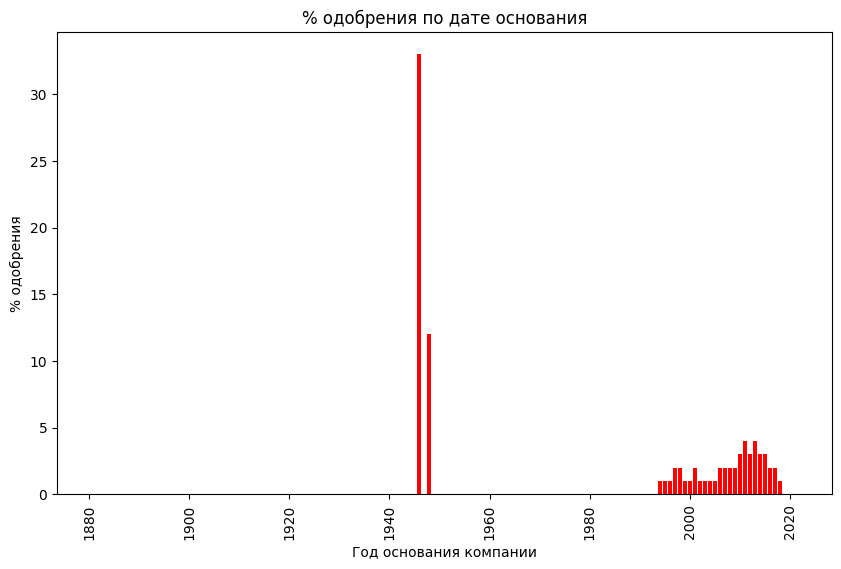

In [64]:
plt.figure(figsize=(10, 6)) 
plt.bar(time_group.sort_index(ascending=True).index, time_group['Year_%'], color='red')
plt.xlabel('Год основания компании')
plt.ylabel('% одобрения')
plt.title('% одобрения по дате основания')
plt.xticks(rotation=90)
plt.show()

In [ ]:
# Исключим 1946 и 1948 год для наглядности графика

plt.figure(figsize=(10, 6)) 
plt.bar(time_group.sort_index(ascending=True).index, time_group['Year_%'], color='red')
plt.xlabel('Год основания компании')
plt.ylabel('% одобрения')
plt.title('% одобрения по дате основания')
plt.xticks(rotation=90)
plt.show()

In [24]:
df_clean_nan[(df_clean_nan['Year_origin'] == 1946) | (df_clean_nan['Year_origin'] == 1948)]
# Данные вполне обычные. Не будем их исключать.

,egrulStatus,fullName,hasRegionalSupport,incomeDetail.contracts223.totalCount,incomeDetail.contracts223.totalSum,incomeDetail.contracts44.totalCount,incomeDetail.contracts44.totalSum,incomeDetail.contracts94.totalCount,incomeDetail.contracts94.totalSum,incomeDetail.fedSubsidies.totalCount,...,incomeDetail.grants.totalSum,incomeTotal,opf.name,regionCode,statusDetail.shortName,Year_origin,Month_origin,Year_ogrn,Month_ogrn,Region.type
65643,Ликвидирована,ВОЙСКОВАЯ ЧАСТЬ 15644,False,0,0.0,0,0.00,0,0.00,0,...,0.0,0.00,Общественные организации,30,Действующая,1946,5,2003,1,область
99191,Действует,"ТОВАРИЩЕСТВО СОБСТВЕННИКОВ НЕДВИЖИМОСТИ ""ПЧЕЛК...",False,0,0.0,0,0.00,0,0.00,0,...,0.0,0.00,Товарищества собственников недвижимости,64,Действующая,1948,9,2003,2,область
152528,Действует,"СОЮЗ ""КРАСНОДАРСКОЕ КРАЕВОЕ ОБЪЕДИНЕНИЕ ОРГАНИ...",True,1,180000.0,22,1817289.73,3,614425.56,0,...,0.0,2611715.29,Ассоциации (союзы),23,Действующая,1948,10,2002,12,край
260754,Ликвидирована,ПРОФСОЮЗНЫЙ КОМИТЕТ ДЕТСКОЙ МУНИЦИПАЛЬНОЙ КЛИН...,False,0,0.0,0,0.00,0,0.00,0,...,0.0,0.00,Профсоюзные организации,27,Действующая,1948,10,2018,6,край
329397,Ликвидирована,ПРОФСОЮЗНЫЙ КОМИТЕТ ПРЕПОДАВАТЕЛЕЙ МЕДИЦИНСКОГ...,False,0,0.0,0,0.00,0,0.00,0,...,0.0,0.00,Профсоюзные организации,45,Действующая,1946,6,2012,5,область
330139,Ликвидирована,ПРОФСОЮЗНЫЙ КОМИТЕТ АО КУРГАНТРУБОПРОВОДСТРОЙ,False,0,0.0,0,0.00,0,0.00,0,...,0.0,0.00,Профсоюзные организации,45,Действующая,1948,9,2012,4,область
330830,Ликвидирована,ПРОФСОЮЗНЫЙ КОМИТЕТ ЦЕНТРА СТАНДАРТИЗАЦИИ МЕТР...,False,0,0.0,0,0.00,0,0.00,0,...,0.0,0.00,Профсоюзные организации,45,Действующая,1948,9,2012,4,область
355273,Действует,"ДАЧНЫЙ ПОТРЕБИТЕЛЬСКИЙ КООПЕРАТИВ ""СОЛНЕЧНОЕ""",False,0,0.0,0,0.00,0,0.00,0,...,0.0,0.00,Потребительские кооперативы,50,Действующая,1948,4,2002,10,область
396928,Действует,"НЕГОСУДАРСТВЕННАЯ НЕКОММЕРЧЕСКАЯ ОРГАНИЗАЦИЯ ""...",True,0,0.0,0,0.00,0,0.00,0,...,0.0,0.00,Коллегии адвокатов,39,Действующая,1946,5,2002,12,область
571168,Ликвидирована,ПРОФСОЮЗНЫЙ КОМИТЕТ АО КУРГАНТРАНСМАШПРОЕКТ,False,0,0.0,0,0.00,0,0.00,0,...,0.0,0.00,Профсоюзные организации,45,Действующая,1948,9,2014,6,область


In [25]:
region_group['Year_s'] = round((region_group[True] / region_group.sum(axis=1)) * 100)
region_group.sort_values('%_approve', ascending=False).head(10)

hasRegionalSupport,False,True,%_approve,Year_s
regionName,,,,
Ненецкий автономный округ,306,92,23.0,22.0
Чукотский автономный округ,457,48,10.0,9.0
Ямало-Ненецкий автономный округ,2515,248,9.0,9.0
Магаданская область,1456,94,6.0,6.0
Псковская область,3051,165,5.0,5.0
Республика Калмыкия,1664,89,5.0,5.0
Сахалинская область,3649,181,5.0,5.0
Калининградская область,6576,319,5.0,5.0
Кабардино-Балкарская республика,2406,117,5.0,5.0


In [ ]:
# Удаляем дату
df_clean_nan = df_clean_nan.drop(columns=['originDate.$date'])

# Machine Learning

### Кодирование признаков

In [26]:
# Проанализируем признаки с типом object
object_columns = df_clean_nan.select_dtypes(include=['object']).columns
for ob in list(object_columns):
    print(ob, df_clean_nan[ob].nunique())

egrulStatus 2
fullName 665359
opf.name 272
statusDetail.shortName 5
Region.type 6


egrulStatus - Label Encoder  
statusDetail.shortName и Region.type - One-Hot Encoder, так как уникальных записей немного  
opf.name - Binary Encoder  
fullName - можно удалить

In [27]:
df_ml = df_clean_nan.copy()

le = LabelEncoder()
df_ml['egrulStatus_encoded'] = le.fit_transform(df_ml['egrulStatus'])


ohe = OneHotEncoder(sparse=False)
encoded_columns = ohe.fit_transform(df_ml[['statusDetail.shortName', 'Region.type']])
encoded_columns_df = pd.DataFrame(encoded_columns, columns=ohe.get_feature_names_out(['statusDetail.shortName', 'Region.type']))
df_ml = pd.concat([df_ml, encoded_columns_df], axis=1)


be = BinaryEncoder()
encoded_columns = be.fit_transform(df_ml[['opf.name']])
encoded_columns_df = pd.DataFrame(encoded_columns, columns=be.get_feature_names_out(['opf.name']))
df_ml = pd.concat([df_ml, encoded_columns_df], axis=1)


# Удаляем изначальные признаки
df_ml = df_ml.drop(['egrulStatus', 'statusDetail.shortName', 'Region.type', 'opf.name', 'fullName'], axis=1)
df_ml = df_ml.dropna() # удалим строки nan, который добавились 

c:\Users\Aplatonov\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\preprocessing\_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [28]:

df_ml['regionCode'] = df_ml['regionCode'].astype('int64')
df_ml['Year_origin'] = df_ml['Year_origin'].astype('int64')
df_ml.isna().sum()

hasRegionalSupport                                0
incomeDetail.contracts223.totalCount              0
incomeDetail.contracts223.totalSum                0
incomeDetail.contracts44.totalCount               0
incomeDetail.contracts44.totalSum                 0
incomeDetail.contracts94.totalCount               0
incomeDetail.contracts94.totalSum                 0
incomeDetail.fedSubsidies.totalCount              0
incomeDetail.fedSubsidies.totalSum                0
incomeDetail.grants.totalCount                    0
incomeDetail.grants.totalSum                      0
incomeTotal                                       0
regionCode                                        0
Year_origin                                       0
Month_origin                                      0
Year_ogrn                                         0
Month_ogrn                                        0
egrulStatus_encoded                               0
statusDetail.shortName_В состоянии банкротства    0
statusDetail

In [29]:
df_ml.info()

<class 'pandas.core.frame.DataFrame'>
Index: 746040 entries, 0 to 746536
Data columns (total 38 columns):
 #   Column                                          Non-Null Count   Dtype  
---  ------                                          --------------   -----  
 0   hasRegionalSupport                              746040 non-null  object 
 1   incomeDetail.contracts223.totalCount            746040 non-null  float64
 2   incomeDetail.contracts223.totalSum              746040 non-null  float64
 3   incomeDetail.contracts44.totalCount             746040 non-null  float64
 4   incomeDetail.contracts44.totalSum               746040 non-null  float64
 5   incomeDetail.contracts94.totalCount             746040 non-null  float64
 6   incomeDetail.contracts94.totalSum               746040 non-null  float64
 7   incomeDetail.fedSubsidies.totalCount            746040 non-null  float64
 8   incomeDetail.fedSubsidies.totalSum              746040 non-null  float64
 9   incomeDetail.grants.totalCount 

In [32]:
df_ml.to_csv('data/Таблица для обучения.csv')

### Baseline


In [33]:
df_ds = pd.read_csv('data/Таблица для обучения.csv')

In [34]:
# Выберем интересующие нас признаки, чтобы найти зависимость одобряемости поддержки в зависимости 
# от региона регистрации организации;  
# от возраста организации;  
# от экономической деятельности организации.
features = ['opf.name_0', 'opf.name_1', 'opf.name_2', 'opf.name_3', 'opf.name_4', 'opf.name_5', 'opf.name_6', 'opf.name_7', 'opf.name_8', 'regionCode', 'Year_origin']
target = 'hasRegionalSupport'

# Разделяем данные на обучающую и тестовую выборки
X = df_ds[features]
y = df_ds[target]
y = y.replace({False: 0, True: 1}) # Заменим T/F на 1/0, иначе выдаёт ошибку
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.3, random_state=42)

# Создаем и обучаем модель
model = LogisticRegression()
model.fit(X_train, y_train)

# Предсказываем значения для тестовой выборки
y_pred = model.predict(X_test)

# Оцениваем качество модели
print(classification_report(y_test, y_pred))


c:\Users\Aplatonov\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\Aplatonov\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Aplatonov\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classific

              precision    recall  f1-score   support

           0       0.98      1.00      0.99    220434
           1       0.00      0.00      0.00      3378

    accuracy                           0.98    223812
   macro avg       0.49      0.50      0.50    223812
weighted avg       0.97      0.98      0.98    223812



c:\Users\Aplatonov\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [36]:
y.value_counts(normalize=True)

hasRegionalSupport
0    0.984906
1    0.015094
Name: proportion, dtype: float64

Целевой признак несбалансирован: 98% отказов спонсирования и 2% одобрения.  
Нужно привести выборку к сбалансированному виду.

In [40]:
rus = RandomUnderSampler(random_state=42)

# Применяем андерсэмплинг к целевому признаку
X_resampled, y_resampled = rus.fit_resample(df_ds.drop(target, axis=1), df_ds[target])
y_resampled.value_counts(normalize=True)

hasRegionalSupport
False    0.5
True     0.5
Name: proportion, dtype: float64

In [43]:
X_train_rs, X_test_rs, y_train_rs, y_test_rs = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

model_rs = LogisticRegression(random_state=42)
model_rs.fit(X_train_rs, y_train_rs)

# Предсказываем значения для тестовой выборки
y_pred_rs = model_rs.predict(X_test_rs)

# Выводим отчет о классификации
print(classification_report(y_test_rs, y_pred_rs))

              precision    recall  f1-score   support

       False       0.59      0.98      0.74      2257
        True       0.95      0.31      0.47      2248

    accuracy                           0.65      4505
   macro avg       0.77      0.65      0.60      4505
weighted avg       0.77      0.65      0.60      4505



Точность получилась 65%. Будем стараться увеличить этот показатель за счёт разных алгоритмов.

In [48]:
# Попробуем RandomForestClassifier
X_train_rfc, X_test_rfc, y_train_rfc, y_test_rfc = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

RFC = RandomForestClassifier(random_state=42)
RFC.fit(X_train_rfc, y_train_rfc)

y_pred_rfc = RFC.predict(X_test_rfc)

print(classification_report(y_test_rfc, y_pred_rfc))

              precision    recall  f1-score   support

       False       0.88      0.87      0.88      2257
        True       0.87      0.88      0.88      2248

    accuracy                           0.88      4505
   macro avg       0.88      0.88      0.88      4505
weighted avg       0.88      0.88      0.88      4505



Точность увеличилась до 88%. Уже хороший результат, но попробуем перебрать разные параметры модели.


In [53]:
params = {
    'n_estimators': [400, 500, 600],
    'max_depth': [45, 50, 60, 70],
    'min_samples_split': [9, 10, 11],
    'min_samples_leaf': [1, 2, 3],
    'bootstrap': [True, False]
}

score = make_scorer(accuracy_score)

grid_search = GridSearchCV(
                           estimator=RFC, 
                           param_grid=params, 
                           scoring=score, 
                           cv=5, 
                           n_jobs=-1
)

grid_search.fit(X_train_rfc, y_train_rfc)

GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42), n_jobs=-1,
             param_grid={'bootstrap': [True, False],
                         'max_depth': [45, 50, 60, 70],
                         'min_samples_leaf': [1, 2, 3],
                         'min_samples_split': [9, 10, 11],
                         'n_estimators': [400, 500, 600]},
             scoring=make_scorer(accuracy_score))

In [55]:
# Вывод метрик
print("Лучшие параметры:", grid_search.best_params_)

y_pred_rfc = grid_search.predict(X_test_rfc)

# Выводим отчет о классификации
print(classification_report(y_test_rfc, y_pred_rfc))

Лучшие параметры: {'bootstrap': False, 'max_depth': 50, 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 500}
              precision    recall  f1-score   support

       False       0.89      0.88      0.88      2257
        True       0.88      0.89      0.88      2248

    accuracy                           0.88      4505
   macro avg       0.88      0.88      0.88      4505
weighted avg       0.88      0.88      0.88      4505



Результаты почти не изменились. Учитывая, что изначальные результаты без гиперпараметров были достаточно высокими, можно остановиться на этих показателях.